# CIFAR-10 Models Testing

## Imports and GPU Check

In [11]:
#imports
#Main Library (Actual Neural Network Part)
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import neural_structured_learning as nsl

# #Helper Libraries (in order to interpret and view the data)
import matplotlib.pyplot as plt
import numpy as np

In [12]:
#Prints if a GPU is detected by the TensorFlow system
print(len(tf.config.list_physical_devices('GPU')) > 0)

True


## Importing, Validating, and Scaling the Data

In [13]:
#importing the cifar-10 dataset from tensorflow
from tensorflow.keras.datasets import cifar10 
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

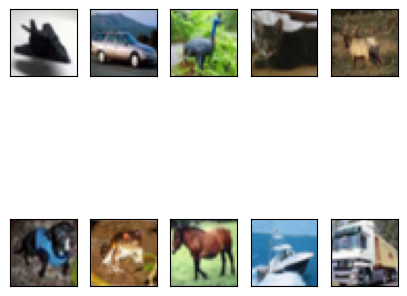

In [16]:
#validating the data (making sure this is the data I want)
fig, ax = plt.subplots(2,5, figsize = (5,5))
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(Y_train == i)[0][0]
    plottable_image = X_train[im_idx]
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].imshow(plottable_image)

In [15]:
#Scaling the Data to be between 0 and 1 (inclusive)
X_train = X_train / 255.0
X_test = X_test / 255.0

## Model Loading

In [17]:
#Base Model Loading
model = tf.keras.models.load_model('complete_saved_cifar10_model')

In [44]:
#Adv Model Loading
adv_model = tf.keras.models.load_model('complete_saved_adv_50_cifar10_model')

## Attack Creation

In [22]:
#epsilon creaiton used for attacks
eps = 8.0/255.0

#Creating the adversarial attack for adversarial training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adv(input_image, input_label, model_type = "adv_model"):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    if(model_type == "model"):
      prediction = model(input_image)
    else:
      prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

def fgsm(input_image, input_label, epsilon = eps, model_type = "adv_model"):
  perturbation = create_adv(input_image, input_label, model_type)
  adv_image = input_image + perturbation * epsilon
  adv_image = tf.clip_by_value(adv_image, 0, 1)

  return adv_image

def pgd(input_image, input_label, num_steps = 7, epsilon = eps, alpha = 2, model_type = "adv_model"):
  adv_image = input_image
  for i in range(num_steps):
    adv_image = fgsm(adv_image, input_label, alpha, model_type)
    perturbation = adv_image - input_image
    perturbation = tf.clip_by_value(perturbation, -epsilon, epsilon)
    adv_image = input_image + perturbation
  
  return adv_image


In [23]:
#FGSM dataset creation
fgsm_x = fgsm(tf.convert_to_tensor(X_test), Y_test)
#PGD dataset creation
pgd_x = pgd(tf.convert_to_tensor(X_test), Y_test)

## Overall Testing

### Benign Image Accuracy

In [53]:
#Base Model
model.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.0176 - accuracy: 0.6618


[1.0176055431365967, 0.6618000268936157]

In [55]:
#Adv Model
adv_model.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.9671 - accuracy: 0.1096


[0.9671450257301331, 0.1096000000834465]

### FGSM Perturbed Image Accuracy

In [56]:
#Base Model
model.evaluate(fgsm_x, Y_test)

  1/313 [..............................] - ETA: 1:37 - loss: 5.6348 - accuracy: 0.0312

c:\Users\Aarush\anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 [==============================] - 2s 7ms/step - loss: 5.9461 - accuracy: 0.0418


[5.946069717407227, 0.04179999977350235]

In [54]:
#Adv Model
adv_model.evaluate(fgsm_x, Y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.1290 - accuracy: 0.0983


[1.1289931535720825, 0.09830000251531601]

### PGD Perturbed Image Accuracy

In [57]:
#Base Model
model.evaluate(pgd_x, Y_test)

313/313 [==============================] - 1s 5ms/step - loss: 6.1944 - accuracy: 0.0318


[6.194400310516357, 0.03180000185966492]

In [58]:
#Adv Model
adv_model.evaluate(pgd_x, Y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.1243 - accuracy: 0.0934


[1.124316692352295, 0.0934000015258789]

## Specific Image Testing

Ground Truth Value

In [86]:
print(show_Y)

[9]


Data Preperation and Index Selection

In [85]:
testing_index = 45
show_X = X_test[testing_index]
show_Y = Y_test[testing_index]
show_fgsm_X = fgsm_x[testing_index]
show_pgd_X = pgd_x[testing_index]

### Benign Image

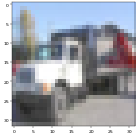

In [87]:
plottable_image_x = show_X[im_idx]
plt.figure(figsize = (5,5), dpi= 32)
plt.imshow(show_X)

In [88]:
#base model prediction
model.predict(np.expand_dims(show_X, axis = 0))

array([[1.7743704e-03, 9.0699298e-03, 1.4374847e-05, 3.0936288e-05,
        2.1790325e-05, 1.8939923e-05, 5.1455800e-08, 1.5751910e-04,
        1.2591864e-03, 9.8765290e-01]], dtype=float32)

In [89]:
#Adv Model Predction
adv_model.predict(np.expand_dims(show_X, axis = 0))

array([[2.1193085e-02, 1.2147369e-01, 2.2418895e-03, 6.5368540e-03,
        1.1568484e-03, 3.2383376e-03, 5.5212884e-05, 3.3568041e-03,
        2.6687473e-02, 8.1405979e-01]], dtype=float32)

### FGSM Image

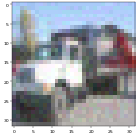

In [90]:
plottable_image_fgsm_x = show_fgsm_X[im_idx]
plt.figure(figsize = (5,5), dpi= 32)
plt.imshow(show_fgsm_X)

In [91]:
#base model prediction
model.predict(np.expand_dims(show_fgsm_X, axis = 0))

array([[3.5212457e-01, 2.0325346e-02, 3.9767798e-02, 1.2224868e-03,
        1.3211429e-01, 9.2177587e-03, 5.6599551e-06, 3.1545943e-01,
        1.1557479e-01, 1.4187786e-02]], dtype=float32)

In [92]:
#Adv Model Predction
adv_model.predict(np.expand_dims(show_fgsm_X, axis = 0))

array([[3.4532271e-02, 1.5869862e-01, 4.3827011e-03, 7.4041015e-03,
        2.1544767e-03, 3.5698763e-03, 1.4182899e-04, 4.0280088e-03,
        4.8529260e-02, 7.3655879e-01]], dtype=float32)

### PGD Image

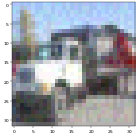

In [93]:
plottable_image_x = show_pgd_X[im_idx]
plt.figure(figsize = (5,5), dpi= 32)
plt.imshow(show_pgd_X)

In [94]:
#base model prediction
model.predict(np.expand_dims(show_pgd_X, axis = 0))

array([[1.4916496e-02, 3.3591833e-04, 5.4714452e-03, 2.1038009e-03,
        2.8851706e-01, 2.0213243e-02, 1.6819093e-05, 6.4372438e-01,
        2.2721071e-02, 1.9796786e-03]], dtype=float32)

In [95]:
#Adv Model Predction
adv_model.predict(np.expand_dims(show_pgd_X, axis = 0))

array([[3.2461617e-02, 9.3020476e-02, 4.3806415e-03, 1.2886214e-02,
        2.8896069e-03, 7.2095301e-03, 2.0307816e-04, 7.0547322e-03,
        2.3260871e-02, 8.1663328e-01]], dtype=float32)